In [433]:
from sentence_transformers import SentenceTransformer
import plotly.express as px
import pandas as pd
import mlflow
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from code import utils
import nltk,re,time,umap
from hdbscan import HDBSCAN
from sentence_transformers import models
from sklearn.preprocessing import normalize
from transformers import AutoModel, AutoTokenizer
from torch import nn
#tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")


In [276]:
%load_ext autoreload
%autoreload 2

In [434]:
#model = SentenceTransformer('bert-base-wikipedia-sections-mean-tokens')
TOP_N = 1000
TRAIN_N = 10000
# load BERT model from Hugging Face
word_embedding_model = models.Transformer(
    'T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb')

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=3, activation_function=nn.Tanh())
# join BERT model and pooling to get the sentence transformer
model = SentenceTransformer(modules=[word_embedding_model, pooling_model,dense_model])

In [388]:
df=utils.load_text_data().head(TOP_N)
df.head()

,kicker,headline,text,seo_title,created_at,updated_at,site,entities_analyzed
article_uid,,,,,,,,
8c7b60bbbbab27058f93ba3114462b0b9b82f79c3cf3e95e52cf8013742b1f89,Tor nach 3 Sekunden!,Blitz-Comeback von Reus,Wenn du bei deinem Comeback nach 223 Tagen nur...,DFB-Pokal: Duisburg - BVB 0:5! 3 Sekunden nach...,2020-09-14 22:39:16,2020-09-14 22:39:16,www.bild.de,0
66ef992ac10f512ce621314bcffcbc542549ba1f52c8b11696e33d8730998aba,Sie stoppten das Schalke-Spiel,Türkgücü-Bosse erklärenihre Pokal-Klage,Es war DER Aufreger der 1. DFB-Pokal-Runde. T...,DFB-Pokal: Sie stoppten das Schalke-Spiel – Tü...,2020-09-14 22:34:15,2020-09-14 22:35:05,www.bild.de,1
bafa8f876a14f50c6010a8ea2ff4de2265e508af13c5007ddb363a4c4b155f4e,Messer-Angriff von Stolberg,Islamist stachschon einmal zu!,Stolberg/Aachen – Der Messerangriff von Stolbe...,Messer-Angriff von Stolberg - Islamist stach...,2020-09-14 22:34:15,2020-09-14 22:35:05,www.bild.de,1
e353f0b8121a6f0addf3ea3ca5eead419c904d283284fcffcf913ff6f2f39b1c,Hertha verschenkt Machtzentrale,Die neuen Hierarchien der 18 Klubs,Die neue Serie „Die neuen Hierarchien der 18 K...,1. Bundesliga: Die neuen Hierarchien der 18 Kl...,2020-09-14 22:34:15,2020-09-14 22:35:05,www.bild.de,1
f168dc072b52b38187937175639830ef066209100ffaeea780cb03cd943706d3,Verletzte und neue Offensive,Gisdol schon vorm Start unter Druck!,Das hatte sich Markus Gisdol (50) bei seiner V...,1. FC Köln: Markus Gisdol schon vor Liga-Start...,2020-09-14 22:33:16,2020-09-14 22:34:07,www.bild.de,1


article_uid
8c7b60bbbbab27058f93ba3114462b0b9b82f79c3cf3e95e52cf8013742b1f89    Wenn du bei deinem Comeback nach 223 Tagen nur...
66ef992ac10f512ce621314bcffcbc542549ba1f52c8b11696e33d8730998aba    Es war DER Aufreger der 1. DFB-Pokal-Runde.  T...
bafa8f876a14f50c6010a8ea2ff4de2265e508af13c5007ddb363a4c4b155f4e    Stolberg/Aachen – Der Messerangriff von Stolbe...
e353f0b8121a6f0addf3ea3ca5eead419c904d283284fcffcf913ff6f2f39b1c    Die neue Serie „Die neuen Hierarchien der 18 K...
f168dc072b52b38187937175639830ef066209100ffaeea780cb03cd943706d3    Das hatte sich Markus Gisdol (50) bei seiner V...
                                                                                          ...                        
44085af4cdc4946218ad71e91ccd52de07ce67432ab345281dd3477164e0ea26    Hannover – Erst im Juli hatte das Wirtschaftsm...
ac99c98bf79b0535351de210d36ce132dc82d99462ff0ee357d614ab13feb320    Nürnberg –  Wer kennt das nicht: Beim Wochenei...
06af749227495b2143364ab4efd35895d560b31d4d61

In [408]:
pdf=utils.preprocess_text(df)
df['mix'] = df['kicker'] + " " + df['headline'] +" "+ df["seo_title"] + df["text"].apply(lambda x: " ".join(x.split(" ")[:150]))
pdf_mix = utils.preprocess_text(df,col="mix")
pdf_mix[0][:250]

'tor nach sekunden blitz-comeback von reus dfb-pokal duisburg bvb sekunden nach einwechslung reus mit blitz-torfussballwenn du bei deinem comeback nach tagen nur drei sekunden und genau einen ballkontakt für dein erstes pflichtspieltor brauchst wahnsi'

In [332]:

start_time = time.time()

embeddings = model.encode(pdf,show_progress_bar=True)
print("--- %s seconds ---" % (time.time() - start_time))



--- 110.85381293296814 seconds ---


In [333]:

print(embeddings.shape)
umap_data = umap.UMAP(n_neighbors=50, n_components=3, min_dist=0.0, metric='cosine').fit_transform(embeddings)


(1000, 768)


In [334]:
umap_embeddings = umap.UMAP(n_neighbors=10, 
                            n_components=384, 
                            metric='cosine').fit_transform(embeddings)


In [335]:
cluster = HDBSCAN(min_cluster_size=6,alpha=0.88,cluster_selection_epsilon=0.11,
                          prediction_data=True
                          ,metric='euclidean',                     min_samples=3,
                          cluster_selection_method='eom',approx_min_span_tree=True).fit(umap_embeddings)

In [417]:
def cluster_and_reduce(embeddings,one_day=False):
    umap_data = umap.UMAP(n_neighbors=50, n_components=3, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    print(">> Reducing dimensionality from {} to {} ...".format(embeddings.shape[1],str(384)))
    if len(embeddings) > 384:
        umap_embeddings = umap.UMAP(n_neighbors=15, 
                                    n_components=384, 
                                    metric='cosine').fit_transform(embeddings)
    else:
        umap_embeddings = umap.UMAP(n_neighbors=15, 
                                    n_components=384, 
                                    metric='cosine',init="random").fit_transform(embeddings)

    params = {"min_cluster_size":6,"alpha":0.88,"cluster_selection_epsilon":0.11
                          ,"metric":'euclidean',"min_samples":3,
                          "cluster_selection_method":'eom',"approx_min_span_tree":True}
        
        
    print(">> Clustering...")
    clusters = HDBSCAN(**params).fit_predict(umap_embeddings)
    return umap_data,clusters


cluster_and_reduce(embeddings)

(array([[ 2.6620736, 20.392752 , 12.286615 ],
        [ 2.968329 , 19.33849  , 11.494134 ],
        [ 6.1654572, 17.709917 , 10.573609 ],
        ...,
        [ 4.2898464, 19.634733 , 11.115282 ],
        [ 4.7047987, 20.296906 ,  9.877477 ],
        [ 4.9463596, 19.99121  ,  9.6774435]], dtype=float32),
 array([-1, 45, 44, 52, 53, 52, 54, 35, 50, 14, -1, 47, 40, 50, 46, 10, 17,
        43,  2, -1, -1, 43, 43, 46, 23, 17, 46, 46, -1, -1, 47, 14,  1, -1,
        46,  8, 26, 54, 50, 32, -1, -1, 54, -1,  2, -1, -1, 53, 54, 33, 52,
        53, 44, 27, 40, 38, 54, -1, -1,  9,  8, -1,  7, 16, 54, 25, 12, 45,
        -1, -1, -1, -1, 54, 54,  9, 52, 54, 23,  1, 35,  1, 48, 52, 55, 42,
        -1, -1, 52, 53,  7,  7,  1, 52, 25,  5, 31, -1, 33, 46, 53,  2, -1,
        29, 13, 23,  2,  9, -1, -1, 11, -1, -1, 53, 15, 20, 25, 14, 43,  0,
         7, -1, 46, -1, -1,  2,  2,  3,  1, -1, 29, -1, 13, 51,  1, -1, -1,
        -1, -1, 14, 25, -1, -1,  5, 42, 24, 27, -1, 52, 22,  7, 14,  7, 40,
        26

In [337]:
# Prepare data
result = pd.DataFrame(umap_data, columns=['x', 'y','z'])
result['labels'] = cluster.labels_
result['headline'] = df.head(TOP_N)["seo_title"].values
result['seo_title'] = df.head(TOP_N)["headline"].values

result['created_at'] = df.head(TOP_N)["created_at"].dt.date.values
result.sort_values(by="created_at")
result['created_at'] = result.created_at.apply(str)
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
print("Outliers: {} | Clustered: {} | {} \n Cluster count: {} ".format(len(outliers),len(clustered),
                                                                 (len(clustered)/(len(outliers)+len(clustered)))
                                                                 ,len(clustered.labels.unique())))

result

Outliers: 166 | Clustered: 834 | 0.834 
 Cluster count: 55 


,x,y,z,labels,headline,seo_title,created_at
0,1.279704,5.169715,18.832092,48,DFB-Pokal: Duisburg - BVB 0:5! 3 Sekunden nach...,Blitz-Comeback von Reus,2020-09-14
1,1.754680,5.450720,17.544006,27,DFB-Pokal: Sie stoppten das Schalke-Spiel – Tü...,Türkgücü-Bosse erklärenihre Pokal-Klage,2020-09-14
2,4.787379,6.998209,16.223639,34,Messer-Angriff von Stolberg - Islamist stach...,Islamist stachschon einmal zu!,2020-09-14
3,0.612632,4.828188,18.133574,51,1. Bundesliga: Die neuen Hierarchien der 18 Kl...,Die neuen Hierarchien der 18 Klubs,2020-09-14
4,0.671160,5.125428,18.046736,53,1. FC Köln: Markus Gisdol schon vor Liga-Start...,Gisdol schon vorm Start unter Druck!,2020-09-14
...,...,...,...,...,...,...,...
995,3.169978,6.612284,17.211290,42,Weil Verdi nicht mitspielt - VerkaufsZOFFene S...,VerkaufsZOFFene Sonntage,2020-09-09
996,2.501390,7.586154,16.993389,26,Erfindung aus Nürnberg - Frischer Salat aus de...,Frischer Salat aus dem Automaten,2020-09-09
997,2.573100,6.529678,17.833344,41,OB Henriette Reker: „Klimaneutrales Köln will ...,Reker: „Klimaneutrales Köln will ich noch erle...,2020-09-09
998,1.996269,6.509957,18.317190,-1,NFL: „Vollmer und Kuhn“-Show ist der Football-...,Buccaneers lösen Versprechenvon Bradys Ex-Klub...,2020-09-09


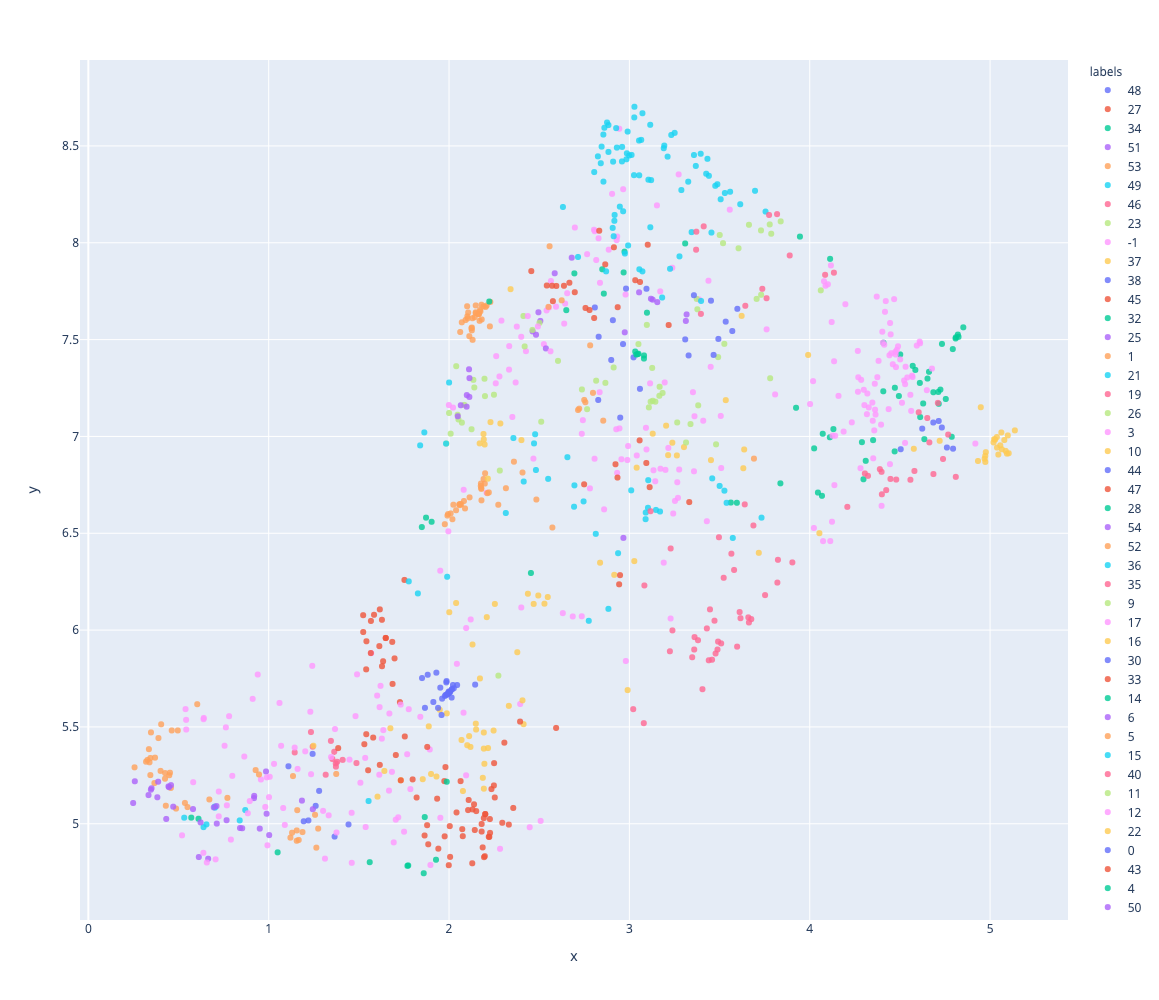

In [338]:
def scatter_plot(result):
    result["labels"] = result.labels.apply(str)
    fig = px.scatter(result, x="x", y="y",hover_name="headline",hover_data=["created_at"], color = "labels",opacity=0.8)
    fig["layout"].pop("updatemenus")
    fig.update_layout(
         height=1000)
    fig.show()
    
result["labels"] = result.labels.apply(str)
fig = px.scatter(result, x="x", y="y",hover_name="headline",hover_data=["created_at"], color = "labels",opacity=0.8)
fig["layout"].pop("updatemenus")
fig.update_layout(
     height=1000)
fig.show()

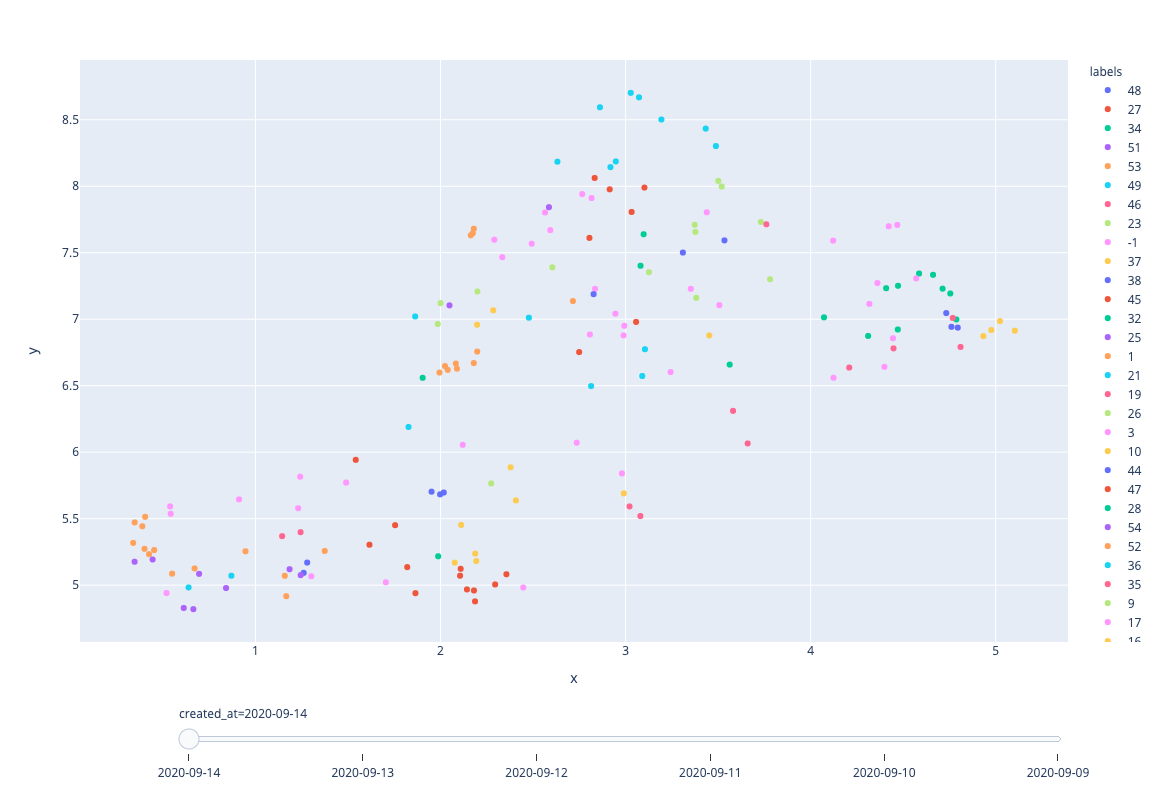

In [349]:

fig = px.scatter(result, x="x", y="y",hover_name="headline", color = "labels", animation_frame="created_at")
fig["layout"].pop("updatemenus")
fig.update_layout(
     height=800)
fig.show()

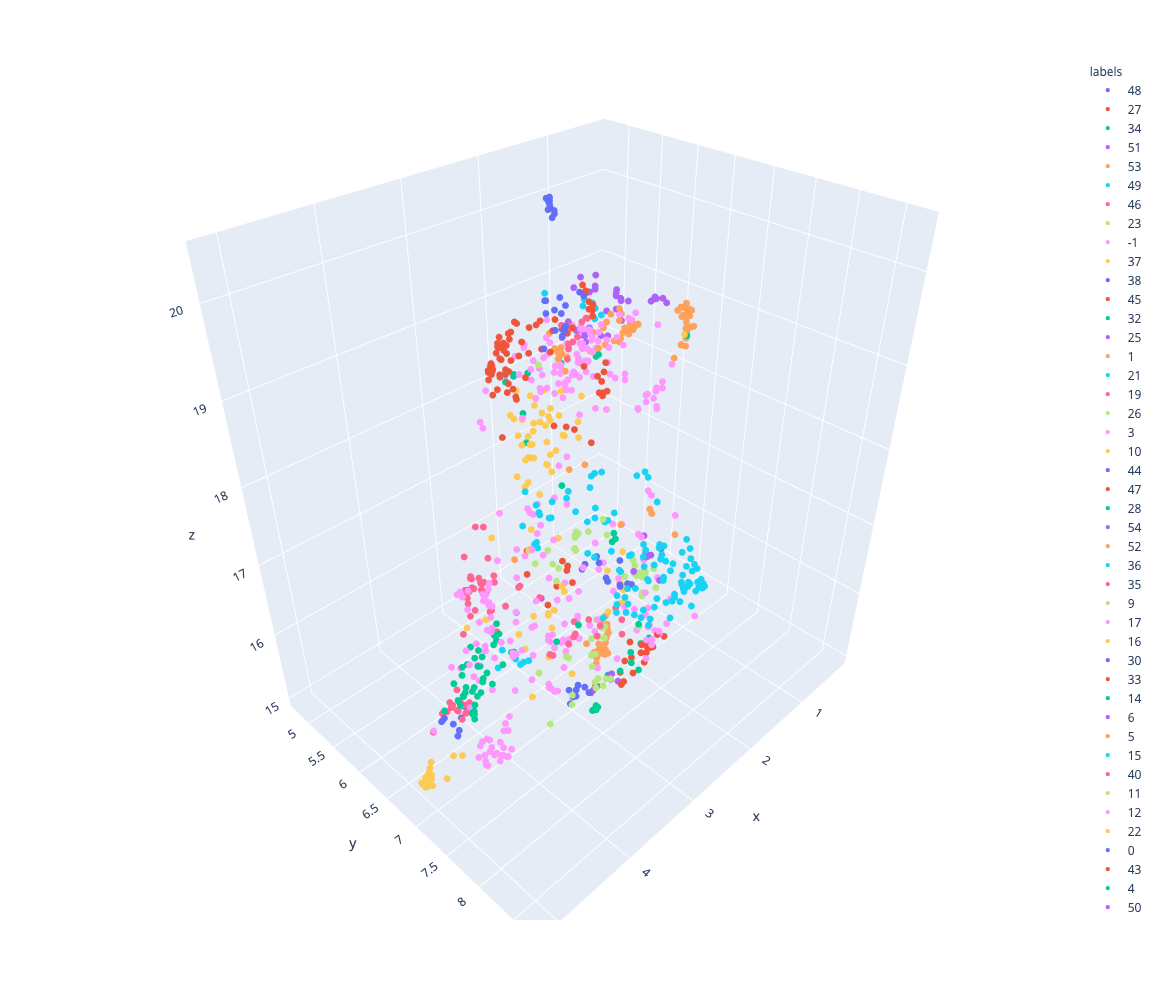

In [340]:


fig = px.scatter_3d(
    result, x='x', y='y', z='z',hover_name="headline",
    color='labels', labels={'color': 'species'}
)
fig.update_traces(marker_size=4)
fig.update_layout(
     height=1000)
fig.show()


In [418]:
def c_tf_idf(documents, m, ngram_range=(1, 1),remove_stop_words=True):
    if remove_stop_words:
        def remove_stop_words(doc):
            for sword in utils.STOPWORDS:
                doc=doc.replace(sword,"")
                return doc
        documents=np.array(list(map(remove_stop_words, documents)))
    
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [419]:
docs_df = pd.DataFrame(pdf_mix, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] =df.index.values#df["article_uid"]#range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})



tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(pdf))
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
top_3_words_per_topic = pd.DataFrame([(k," | ".join([e[0] for e in v][:5]))  for (k,v) in top_n_words.items()],columns=["Topic","top_n_words"])

top_3_words_per_topic["Topic"]=top_3_words_per_topic["Topic"].apply(str)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)


,Topic,Size
0,-1,166
37,36,71
46,45,49
18,17,39
20,19,31
6,5,30
38,37,30
2,1,29
35,34,28
54,53,27


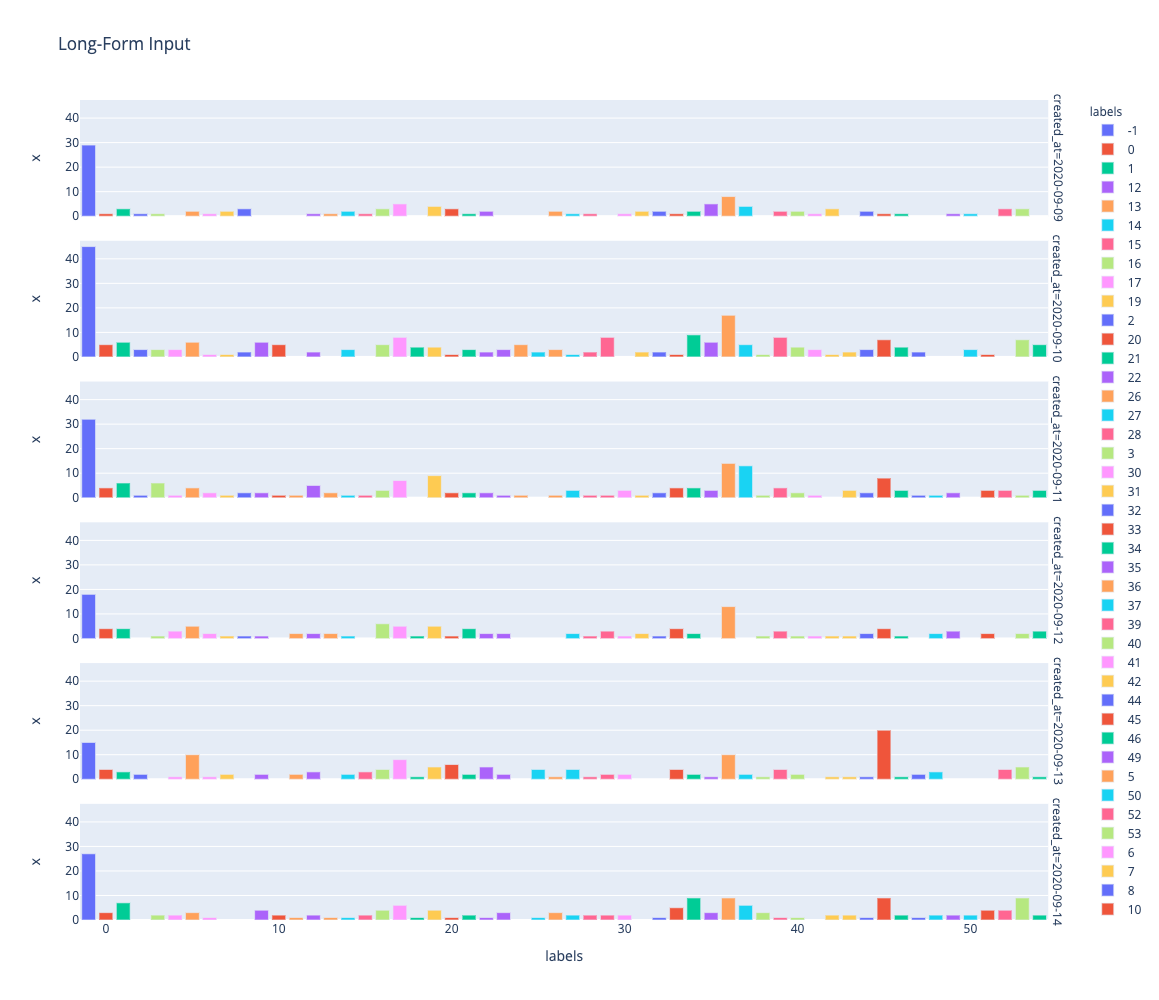

In [412]:
results = pd.merge(result, top_3_words_per_topic, how='left', left_on="labels",right_on="Topic")
results.groupby(["created_at",'labels',"top_n_words"]).count()

fig = px.bar(results.groupby(["created_at",'labels',"top_n_words"]).count().reset_index(), x="labels", y="x", color="labels",hover_name="top_n_words",title="Long-Form Input",facet_row="created_at")
fig.update_layout(
     height=1000)

fig.show()

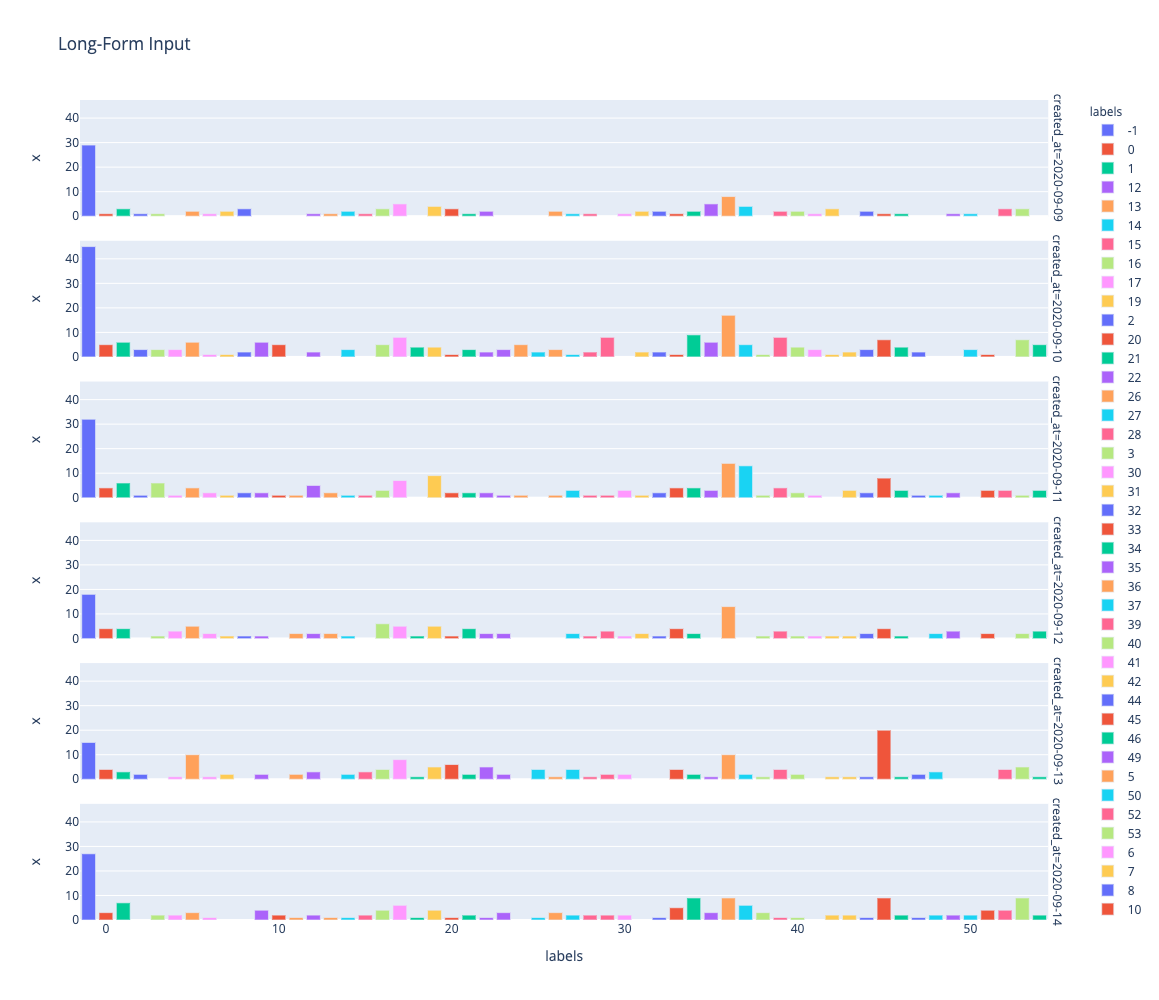

In [390]:
fig = px.bar(results.groupby(["created_at",'labels',"top_n_words"]).count().reset_index(), x="labels", y="x", color="labels",hover_name="top_n_words",title="Long-Form Input",facet_row="created_at")
fig.update_layout(
     height=1000)

fig.show()

In [311]:
df=utils.load_text_data().head(10000)
#pdf=utils.preprocess_text(df)
two_weeks_arr = [df[df.created_at.dt.date == pd.to_datetime("{}/09/2020".format(day),dayfirst=True)] for day in range(2,15)]


#df = df[df.created_at.dt.date == pd.to_datetime("14/09/2020",dayfirst=True)]

In [304]:
#full_embeddings = np.load("./embeddings.npy")


--- 28.214051246643066 seconds ---
Outliers: 17 | Clustered: 228 | 0.9306122448979591 
 Cluster count: 10 


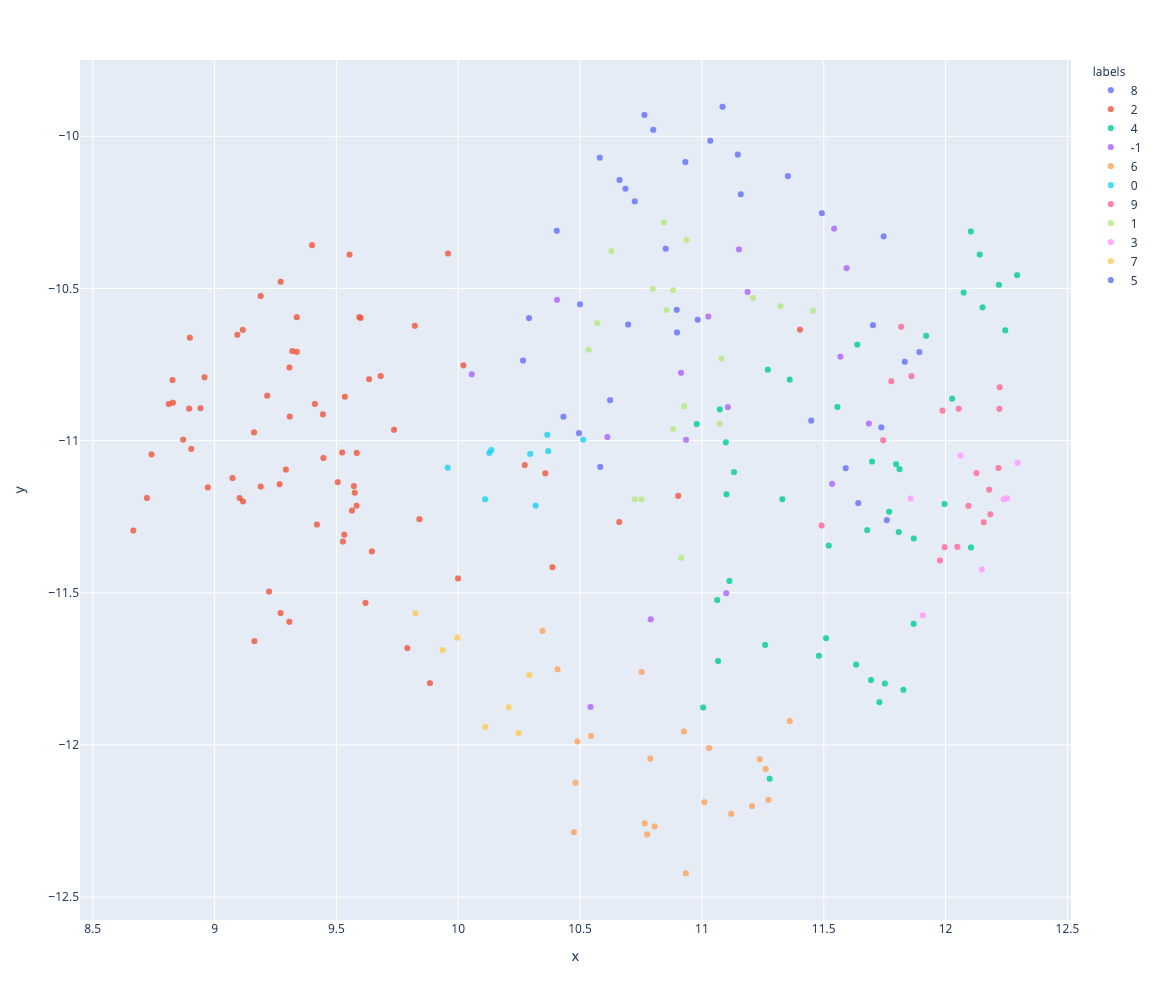

In [414]:
def bert_topic_model(df):
    start_time=time.time()
    pdf=utils.preprocess_text(df)
    emb= model.encode(pdf,show_progress_bar=True)
    umap_data, cluster_labels =cluster_and_reduce(emb)
    result = pd.DataFrame(umap_data, columns=['x', 'y','z'])
    result['labels'] = cluster_labels
    result['headline'] = df["seo_title"].values
    result['seo_title'] = df["headline"].values
    result['created_at'] = df["created_at"].dt.date.values
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    print("--- %s seconds ---" % (time.time() - start_time))

    print("Outliers: {} | Clustered: {} | {} \n Cluster count: {} ".format(len(outliers),len(clustered),
                                                                 (len(clustered)/(len(outliers)+len(clustered)))
                                                                 ,len(clustered.labels.unique())))
    
    docs_df = pd.DataFrame(pdf, columns=["Doc"])
    docs_df['Topic'] = cluster_labels
    docs_df['Doc_ID'] =df.index.values#df["article_uid"]#range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    return result,docs_per_topic

res,docs_per_topic =bert_topic_model(two_weeks_arr[1])

scatter_plot(res)


In [420]:
two_weeks_res = [bert_topic_model(day)[0] for day in two_weeks_arr]


--- 35.987898111343384 seconds ---
Outliers: 33 | Clustered: 246 | 0.8817204301075269 
 Cluster count: 12 



--- 38.31494379043579 seconds ---
Outliers: 46 | Clustered: 199 | 0.8122448979591836 
 Cluster count: 13 



--- 34.016526222229004 seconds ---
Outliers: 32 | Clustered: 176 | 0.8461538461538461 
 Cluster count: 11 



--- 25.576088190078735 seconds ---
Outliers: 15 | Clustered: 146 | 0.906832298136646 
 Cluster count: 12 



--- 37.52465105056763 seconds ---
Outliers: 12 | Clustered: 169 | 0.9337016574585635 
 Cluster count: 13 



--- 49.15345883369446 seconds ---
Outliers: 35 | Clustered: 193 | 0.8464912280701754 
 Cluster count: 9 



--- 45.62162375450134 seconds ---
Outliers: 0 | Clustered: 244 | 1.0 
 Cluster count: 2 



--- 35.64262318611145 seconds ---
Outliers: 25 | Clustered: 212 | 0.8945147679324894 
 Cluster count: 17 



--- 37.757420778274536 seconds ---
Outliers: 29 | Clustered: 206 | 0.8765957446808511 
 Cluster count: 14 



--- 29.424973964691162 seconds ---
Outliers: 34 | Clustered: 153 | 0.8181818181818182 
 Cluster count: 14 



--- 21.722954034805298 seconds ---
Outliers: 4 | Clustered: 125 | 0.9689922480620154 
 Cluster count: 6 



--- 26.20570993423462 seconds ---
Outliers: 27 | Clustered: 135 | 0.8333333333333334 
 Cluster count: 10 



--- 27.014282941818237 seconds ---
Outliers: 13 | Clustered: 159 | 0.9244186046511628 
 Cluster count: 7 


In [467]:
def remove_seo_title_marker(headline,remove_section=False):
    tmp = headline.replace('bild.de',"")
    tmp = tmp.replace('Bild.de',"")
    tmp = tmp.replace('*** BILDplus Inhalt ***',"")
    tmp = tmp.replace(u'\xa0', u' ')
    if remove_section:
        tmp=[wrds.lstrip().rstrip() for wrds in tmp.split("-")[:-2]]
    else:
        tmp=[wrds.lstrip().rstrip() for wrds in tmp.split("-")[:-1]]
    return " ".join(tmp).lstrip().rstrip()

df["seo_title"].apply(remove_headline_marker)[50:70].values

array(['1. Bundesliga: Die neuen Hierarchien der Klubs – die Serie bei BILD Bundesliga',
       'HSV: Julian Pollersbeck ist klar mit Lyon! Wer kommt als Ersatz? 2. Bundesliga',
       'Haftbefehl wegen Wiederholungsgefahr Stach Stolberger Messer Angreifer schon einmal zu? Köln',
       'Kein Verbrechen wegen Corona? 89 Prozent mehr Enkeltrick! Bremen',
       'In Celle (Niedersachsen): Juwelier erschießt Räuber News',
       '„FameMaker“: Wie Stefan Raab die Fäden weiter in der Hand hat Leute',
       'Tempo, Wucht und Tor Garantie: Darum will Hertha Kölns Jhon Córdoba Bundesliga',
       'Angeklagter fehlt zum Auftakt Richter ordnet Haftbefehl an Saarland',
       'Neubrandenburg: Extremismusverdacht! Razzia bei Soldat (40) Mecklenburg Vorpommern',
       'Deutsche Börse: Dax schließt kaum verändert Wirtschaft',
       'Corona Lage vor den Herbstferien Wo kann ich jetzt noch Urlaub machen? Wirtschaft',
       'Hygienekonzept genehmigt Lok darf 3634 Fans ins Stadion lassen Fussball',
